In [1]:
"""
O código usa o método ensemble para combinar as previsões de vários modelos de classificação.
Os modelos individuais são um Decision Tree, um Random Forest, um Gradient Boosting, um Naive Bayes e um CatBoost.
Os dados são carregados de um arquivo CSV e codificados usando one-hot encoding.
Os dados são então divididos em conjuntos de treinamento e teste.
Os modelos individuais são treinados nos dados de treinamento e suas previsões são feitas nos dados de teste.
As previsões dos modelos individuais são combinadas para produzir uma única previsão.
A precisão do modelo ensemble nos dados de teste é calculada.
"""

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [2]:
# Carregar os dados do arquivo CSV
data = pd.read_csv(
    fr"C:\Users\crist\Desktop\dados.csv",
    sep =','
)

# Aplicar a codificação one-hot nas colunas categóricas
data = pd.get_dummies(data, columns=["j_posicao"])
data = pd.get_dummies(data, columns=["j_rota"])
data = pd.get_dummies(data, columns=["j_jardas"])
data = pd.get_dummies(data, columns=["j_catch"])
data = pd.get_dummies(data, columns=["j_area_recepcao"])

# Separar as features (X) e o target (y)
X = data.drop(columns=["target"])  # Remover a coluna "target" das features
y = data["target"]

# Aplicar SMOTE para balancear os dados
smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5)  # Ajustar sampling_strategy e k_neighbors conforme necessário
X_resampled, y_resampled = smote.fit_resample(X, y)

# Avaliar a distribuição das classes após o balanceamento
from collections import Counter
print("Distribuição das classes após o balanceamento:", Counter(y_resampled))

# Normalização min-max das features
scaler = MinMaxScaler()
X_resampled_normalized = scaler.fit_transform(X_resampled)

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled_normalized, y_resampled, test_size=0.2, random_state=42)

Distribuição das classes após o balanceamento: Counter({'N': 150, 'PR': 150, 'P': 150})


In [6]:
# Criar os modelos individuais
decision_tree_model = DecisionTreeClassifier(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)
gradient_boosting_model = GradientBoostingClassifier(random_state=42)
naive_bayes_model = MultinomialNB()
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# Definir as distribuições dos hiperparâmetros para a busca aleatória
param_dist_decision_tree = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 5, 10, 20, 50],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2']
}

param_dist_random_forest = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 5, 10, 20, 50],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

param_dist_gradient_boosting = {
    'n_estimators': [50, 100, 150, 200, 250],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

param_dist_naive_bayes = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'class_prior': [None, [0.2, 0.8], [0.5, 0.5]],
    'fit_prior': [True, False],
    'force_alpha': [True, False]
}


param_dist_catboost = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# Definições para validação cruzada interna
n_folds = 5
cv_strategy = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Criar os objetos RandomizedSearchCV com os modelos e as distribuições de hiperparâmetros
random_search_decision_tree = RandomizedSearchCV(decision_tree_model, param_dist_decision_tree, n_iter=25, cv=cv_strategy, scoring='accuracy', random_state=42)
random_search_random_forest = RandomizedSearchCV(random_forest_model, param_dist_random_forest, n_iter=25, cv=cv_strategy, scoring='accuracy', random_state=42)
random_search_gradient_boosting = RandomizedSearchCV(gradient_boosting_model, param_dist_gradient_boosting, n_iter=25, cv=cv_strategy, scoring='accuracy', random_state=42)
random_search_naive_bayes = RandomizedSearchCV(naive_bayes_model, param_dist_naive_bayes, n_iter=25, cv=cv_strategy, scoring='accuracy', random_state=42)
random_search_catboost = RandomizedSearchCV(catboost_model, param_dist_catboost, n_iter=25, cv=cv_strategy, scoring='accuracy', random_state=42)

# Realizar a busca aleatória para encontrar as melhores combinações de hiperparâmetros para cada modelo
random_search_decision_tree.fit(X_resampled_normalized, y_resampled)
random_search_random_forest.fit(X_resampled_normalized, y_resampled)
random_search_gradient_boosting.fit(X_resampled_normalized, y_resampled)
random_search_naive_bayes.fit(X_resampled_normalized, y_resampled)
random_search_catboost.fit(X_resampled_normalized, y_resampled)

# Obter os melhores modelos após a aplicação da busca aleatória
best_decision_tree_model = random_search_decision_tree.best_estimator_
best_random_forest_model = random_search_random_forest.best_estimator_
best_gradient_boosting_model = random_search_gradient_boosting.best_estimator_
best_naive_bayes_model = random_search_naive_bayes.best_estimator_
best_catboost_model = random_search_catboost.best_estimator_

models = {
    "Decision Tree": best_decision_tree_model,
    "Random Forest": best_random_forest_model,
    "Gradient Boosting": best_gradient_boosting_model,
    "Naive Bayes": best_naive_bayes_model,
    "CatBoost": best_catboost_model
}

C:\Users\crist\Desktop\PycharmProjects\Projeto\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\crist\Desktop\PycharmProjects\Projeto\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\crist\Desktop\PycharmProjects\Projeto\venv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\crist\Desktop\PycharmProjects\Projeto\venv\lib\site-packages\sklearn\base.py", line 638

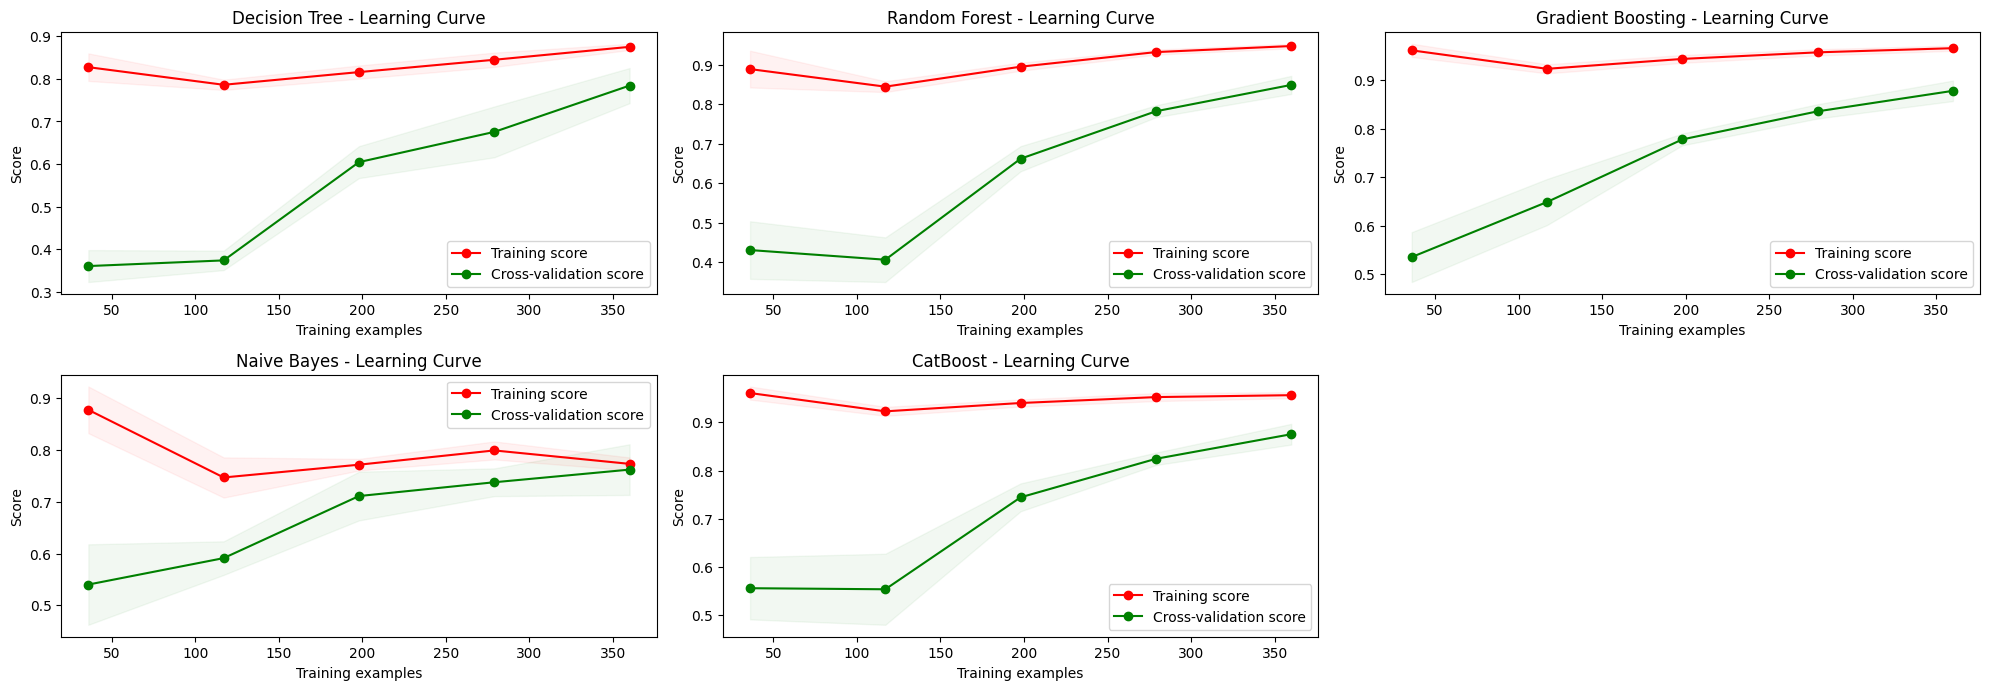

In [8]:
# Ajustando os modelos e plotando a curva de aprendizado
plt.figure(figsize=(20, 10))

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    train_sizes, train_scores, test_scores = learning_curve(model, X_resampled_normalized, y_resampled, cv=cv_strategy)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.subplot(3, 3, i + 1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.05,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.05, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.title(f"{name} - Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [9]:
# Fazer previsões usando cada modelo otimizado
y_pred_decision_tree = best_decision_tree_model.predict(X_test)
y_pred_random_forest = best_random_forest_model.predict(X_test)
y_pred_gradient_boosting = best_gradient_boosting_model.predict(X_test)
y_pred_naive_bayes = best_naive_bayes_model.predict(X_test)
y_pred_catboost = best_catboost_model.predict(X_test).squeeze()

ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_random_forest[i], y_pred_gradient_boosting[i], y_pred_naive_bayes[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

In [10]:
# DADOS DO MODELO

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
ensemble_classification_report =classification_report(y_test, ensemble_predictions) 
print(ensemble_classification_report)

# Matriz de confusão do modelo de ensemble nos dados de teste
conf_matrix = confusion_matrix(y_test, ensemble_predictions)
print("Matriz de Confusão:")
print(conf_matrix)

# Avaliar o modelo com validação cruzada
cv_scores_decision_tree = cross_val_score(best_decision_tree_model, X_resampled_normalized, y_resampled, cv=15, scoring='accuracy')
cv_scores_random_forest = cross_val_score(best_random_forest_model, X_resampled_normalized, y_resampled, cv=15, scoring='accuracy')
cv_scores_gradient_boosting = cross_val_score(best_gradient_boosting_model, X_resampled_normalized, y_resampled, cv=15, scoring='accuracy')
cv_scores_naive_bayes = cross_val_score(naive_bayes_model, X_resampled_normalized, y_resampled, cv=15, scoring='accuracy')
cv_scores_catboost = cross_val_score(best_catboost_model, X_resampled_normalized, y_resampled, cv=15, scoring='accuracy')

print("Acurácia média com validação cruzada - Decision Tree:", cv_scores_decision_tree.mean())
print("Acurácia média com validação cruzada - Random Forest:", cv_scores_random_forest.mean())
print("Acurácia média com validação cruzada - Gradient Boosting:", cv_scores_gradient_boosting.mean())
print("Acurácia média com validação cruzada - Naive Bayes:", cv_scores_naive_bayes.mean())
print("Acurácia média com validação cruzada - CatBoost:", cv_scores_catboost.mean())

Acurácia do ensemble nos dados de teste: 0.8777777777777778
              precision    recall  f1-score   support

           N       0.84      0.91      0.88        35
           P       0.86      0.83      0.84        23
          PR       0.93      0.88      0.90        32

    accuracy                           0.88        90
   macro avg       0.88      0.87      0.87        90
weighted avg       0.88      0.88      0.88        90

Matriz de Confusão:
[[32  1  2]
 [ 4 19  0]
 [ 2  2 28]]
Acurácia média com validação cruzada - Decision Tree: 0.8288888888888889
Acurácia média com validação cruzada - Random Forest: 0.8311111111111112
Acurácia média com validação cruzada - Gradient Boosting: 0.8733333333333334
Acurácia média com validação cruzada - Naive Bayes: 0.7533333333333335
Acurácia média com validação cruzada - CatBoost: 0.8733333333333334


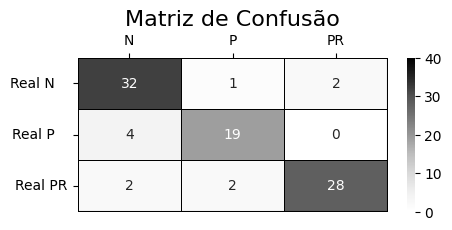

In [11]:
#Matriz Confusão

# Personalize os rótulos e o título
labels = ["N", "P", "PR"]
labels_pred = ["Real N   ", "Real P   ", "Real PR"]
title = "Matriz de Confusão"

# Crie um mapa de calor da matriz de confusão
fig, ax = plt.subplots(figsize=(5, 2))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    cmap="Greys", 
    vmin=0, 
    vmax=40, 
    cbar=True, 
    xticklabels=labels, 
    yticklabels=labels_pred, 
    linewidths=0.5,
    linecolor='black'
)

# # Personalize as bordas do mapa de calor
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_color('black')
# ax.spines['top'].set_color('black')
# ax.spines['right'].set_color('black')

# Adicione linhas
#ax.axhline(y=0, color='black', linewidth=1.5)
#ax.axvline(x=0, color='black', linewidth=1.5)
ax.axhline(y=len(labels_pred), color='black', linewidth=1.5)
ax.axvline(x=len(labels), color='black', linewidth=1.5)

# Defina a cor de fundo como preto
# ax.patch.set_facecolor('black')

# Personalize as margens do mapa de calor
# plt.margins(0)

# Mova os rótulos do eixo x para a parte superior
plt.gca().xaxis.tick_top()

# Adicione um título ao gráfico
plt.title(title, fontsize=16, color='black')

# Exiba o gráfico
plt.show()

In [12]:
# TESTES ENSEMBLE
# y_pred_decision_tree = best_decision_tree_model.predict(X_test)
# y_pred_random_forest = best_random_forest_model.predict(X_test)
# y_pred_gradient_boosting = best_gradient_boosting_model.predict(X_test)
# y_pred_naive_bayes = naive_bayes_model.predict(X_test)
# y_pred_catboost = catboost_model.predict(X_test).squeeze()

# TESTE 1

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 1:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 2

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_random_forest
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_random_forest[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 2:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 3

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_gradient_boosting
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_gradient_boosting[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 3:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 4

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_naive_bayes
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_naive_bayes[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 4:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 5

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 5:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 12

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_random_forest
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_random_forest[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 12:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 13

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_gradient_boosting
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_gradient_boosting[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 13:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 14

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_naive_bayes
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_naive_bayes[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 14:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 15

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 15:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 23

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_random_forest,
#     y_pred_gradient_boosting
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_random_forest[i], y_pred_gradient_boosting[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 23:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 24

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_random_forest,
#     y_pred_naive_bayes
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_random_forest[i], y_pred_naive_bayes[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 24:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 25

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_random_forest,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_random_forest[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 25:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 34

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_gradient_boosting,
#     y_pred_naive_bayes
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_gradient_boosting[i], y_pred_naive_bayes[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 34:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 35

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_gradient_boosting,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_gradient_boosting[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 35:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 45

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_naive_bayes,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_naive_bayes[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 45:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 123

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_random_forest,
#     y_pred_gradient_boosting
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_random_forest[i], y_pred_gradient_boosting[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 123:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 124

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_random_forest,
#     y_pred_naive_bayes
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_random_forest[i], y_pred_naive_bayes[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 124:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 125

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_random_forest,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_random_forest[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 125:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 134

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_gradient_boosting,
#     y_pred_naive_bayes
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_gradient_boosting[i], y_pred_naive_bayes[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 134:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 135

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_gradient_boosting,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_gradient_boosting[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 135:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 145

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_naive_bayes,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_naive_bayes[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 145:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 234

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_random_forest,
#     y_pred_gradient_boosting,
#     y_pred_naive_bayes
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_random_forest[i], y_pred_gradient_boosting[i], y_pred_naive_bayes[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 234:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 235

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_random_forest,
#     y_pred_gradient_boosting,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_random_forest[i], y_pred_gradient_boosting[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 235:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 245

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_random_forest,
#     y_pred_naive_bayes,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_random_forest[i], y_pred_naive_bayes[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 245:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 345

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_gradient_boosting,
#     y_pred_naive_bayes,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_gradient_boosting[i], y_pred_naive_bayes[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 345:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 1234

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_random_forest,
#     y_pred_gradient_boosting,
#     y_pred_naive_bayes
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_random_forest[i], y_pred_gradient_boosting[i], y_pred_naive_bayes[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 1234:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 1235

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_random_forest,
#     y_pred_gradient_boosting,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_random_forest[i], y_pred_gradient_boosting[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 1235:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 1245

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_random_forest,
#     y_pred_naive_bayes,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_random_forest[i], y_pred_naive_bayes[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 1245:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 1345

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_decision_tree,
#     y_pred_gradient_boosting,
#     y_pred_naive_bayes,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_decision_tree[i], y_pred_gradient_boosting[i], y_pred_naive_bayes[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 1345:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

# TESTE 2345

# Aplicar o modelo de ensemble: voto majoritário
# ensemble_predictions = mode([
#     y_pred_random_forest,
#     y_pred_gradient_boosting,
#     y_pred_naive_bayes,
#     y_pred_catboost
# ], axis=0).mode[0]
ensemble_predictions = []
for i in range(len(y_pred_decision_tree)):
    predictions = [y_pred_random_forest[i], y_pred_gradient_boosting[i], y_pred_naive_bayes[i], y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    ensemble_predictions.append(consensus_class)

# Calcular a acurácia do modelo de ensemble nos dados de teste
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Acurácia do ensemble nos dados de teste 2345:", ensemble_accuracy)

# Outras métricas de avaliação do modelo de ensemble nos dados de teste
print(classification_report(y_test, ensemble_predictions))

Acurácia do ensemble nos dados de teste 1: 0.7444444444444445
              precision    recall  f1-score   support

           N       0.64      0.80      0.71        35
           P       1.00      0.83      0.90        23
          PR       0.74      0.62      0.68        32

    accuracy                           0.74        90
   macro avg       0.79      0.75      0.76        90
weighted avg       0.77      0.74      0.75        90

Acurácia do ensemble nos dados de teste 2: 0.8555555555555555
              precision    recall  f1-score   support

           N       0.83      0.86      0.85        35
           P       0.86      0.83      0.84        23
          PR       0.88      0.88      0.88        32

    accuracy                           0.86        90
   macro avg       0.86      0.85      0.85        90
weighted avg       0.86      0.86      0.86        90

Acurácia do ensemble nos dados de teste 3: 0.8777777777777778
              precision    recall  f1-score   suppor

In [57]:
# DADOS REAL

# Carregar os dados do arquivo CSV
data_real = pd.read_csv(
    fr"C:\Users\crist\Desktop\dados.csv",
    sep =','
)
final_df = pd.DataFrame(data_real, columns=data_real.columns)  # Copiar as features

# Aplicar a codificação one-hot nas colunas categóricas
data_real = pd.get_dummies(data_real, columns=["j_posicao"])
data_real = pd.get_dummies(data_real, columns=["j_rota"])
data_real = pd.get_dummies(data_real, columns=["j_jardas"])
data_real = pd.get_dummies(data_real, columns=["j_catch"])
data_real = pd.get_dummies(data_real, columns=["j_area_recepcao"])

# Separar as features (X)
r_X = data_real.drop(columns=["target"])  # Remover a coluna "target" das features

# Normalização min-max das features
scaler = MinMaxScaler()
r_X_normalized = scaler.fit_transform(r_X)

# Fazer previsões usando o modelo de ensemble otimizado anteriormente
r_y_pred_decision_tree = best_decision_tree_model.predict(r_X_normalized)
r_y_pred_random_forest = best_random_forest_model.predict(r_X_normalized)
r_y_pred_gradient_boosting = best_gradient_boosting_model.predict(r_X_normalized)
r_y_pred_catboost = best_catboost_model.predict(r_X_normalized).squeeze()
 
# Aplicar o modelo de ensemble: voto majoritário
r_ensemble_predictions = []
for i in range(len(r_y_pred_decision_tree)):
    predictions = [r_y_pred_decision_tree[i], r_y_pred_random_forest[i], r_y_pred_gradient_boosting[i], r_y_pred_catboost[i]]
    class_counts = Counter(predictions)
    consensus_class = class_counts.most_common(1)[0][0]
    r_ensemble_predictions.append(consensus_class)

print(r_ensemble_predictions)

# Adicionar os resultados da predição como uma nova coluna ao DataFrame
data_real['resultado'] = r_ensemble_predictions
print(data_real)

# Criar um DataFrame apenas com as features e as previsões
columns_to_remove = [
    'target','a_altura','a_tempo_corrida','a_tempo_corrida_cone','a_distancia_salto','a_altura_salto','d_altura','d_tempo_corrida','d_tempo_corrida_cone','d_distancia_salto','d_altura_salto'
]
final_df.drop(columns=columns_to_remove, inplace=True) # Remover as colunas de variáveis booleanas adicionais
final_df['resultado'] = r_ensemble_predictions  # Adicionar as previsões como uma nova coluna
values_list_df = ['04', '07', '08', '10', '12', '22', '24', '77'] # Criar uma lista com os valores desejados
values_list_jg = ['Pikachu','Geodude','Rattata','Salvador','São Luis','Fortaleza','Maranhão','Chiefs','Boa Vista','Indy'] # Criar uma lista com os valores desejados
final_df.insert(0, 'df', '') # Adicionar uma nova coluna com os valores desejados
final_df.insert(0, 'jg', '') # Adicionar uma nova coluna com os valores desejados
for i in range(len(final_df)): # Iterar sobre os índices do DataFrame e preencher a nova coluna com os valores apropriados
    value_index_df = i // 40  # Calcula o índice correspondente na lista de valores
    value_index_df = min(value_index_df, len(values_list_df) - 1)  # Garante que o índice não exceda o comprimento da lista de valores
    final_df.at[i, 'df'] = values_list_df[value_index_df]  # Atribui o valor correspondente na lista de valores à nova coluna
    value_index_jg = value_index_jg = i // 4 % len(values_list_jg)  # Calcula o índice correspondente na lista de valores
    value_index_jg = min(value_index_jg, len(values_list_jg) - 1) # Garante que o índice não exceda o comprimento da lista de valores
    final_df.at[i, 'jg'] = values_list_jg[value_index_jg]  # Atribui o valor correspondente na lista de valores à nova coluna

# Exportar o DataFrame atualizado para um arquivo CSV
final_df.to_csv(
    fr"C:\Users\crist\Desktop\resultado_dados.csv",
    sep =';',
    index=False) # Isso exportará o DataFrame para um arquivo CSV sem índices

['N', 'PR', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'PR', 'N', 'N', 'PR', 'N', 'N', 'N', 'N', 'N', 'P', 'N', 'PR', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'PR', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'PR', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'PR', 'N', 'N', 'PR', 'N', 'N', 'N', 'N', 'N', 'P', 'N', 'PR', 'N', 'N', 'N', 'N', 'N', 'P', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'PR', 'N', 'PR', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'N', 'PR', 'N', 'N', 'N', 'N', 'N', 'P', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'PR', 'N', 'N', 'PR', 'N', 'N', 'N', 'N', 'PR', 'N', 'N', 'PR', 'N', 'N', 'N', 'N', 'N', 'P', 'N', 'PR', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'PR', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'PR', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'PR', 'N', 'N', 'P', 'N', 'N', 'N', 'N', 'N', 'P', 'N', 'PR', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'